In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import product
import xgboost as xgb
#from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import combinations
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

In [6]:
def woe(df_train, feature_name, target_name, df_test=None):
    def group_woe(group):
        event = float(group.sum())
        non_event = group.shape[0] - event

        rel_event = (event+0.5) / (event_total+0.5)
        rel_non_event = (non_event+0.5) / (non_event_total+0.5)

        return np.log(rel_non_event / rel_event) 

    if df_train[target_name].nunique() > 2:
        raise ValueError('Target column should be binary (1/0).')

    event_total = float(df_train[df_train[target_name] == 1.0].shape[0])
    non_event_total = float(df_train.shape[0] - event_total)

    if df_test is None:
        return df_train.groupby(feature_name)[target_name].transform(group_woe)
    else:    
        dict_woe = dict(zip(df_train[feature_name], 
            pd.to_numeric(df_train.groupby(feature_name)[target_name].transform(group_woe))))
        dict_woe = defaultdict(lambda: 0, dict_woe)
        return pd.to_numeric(df_test[feature_name].map(lambda x : dict_woe[x])),\
                pd.to_numeric(df_train[feature_name].map(lambda x : dict_woe[x]))

In [3]:
RANDOM_STATE = 2017

In [4]:
#cutting based on percentile
def percentile_cut(df_train, feature_name, df_test=None, qcut=100):
    if df_test is None:
        return pd.cut(df_train[feature_name].fillna(-1), 
               np.unique(np.percentile(df_train[feature_name].fillna(-1), np.arange(0,100+100./qcut,100./qcut)
                                      )
                        )
              ,include_lowest=True)
    else:
        #union = pd.concat([df_train[feature_name].fillna(-1), df_test[feature_name].fillna(-1)], axis = 0)
        return pd.cut(df_test[feature_name].fillna(-1), 
               np.unique(np.percentile(df_train[feature_name].fillna(-1), np.arange(0,100+100./qcut,100./qcut)
                                      )
                        )
              ,include_lowest=True).astype('object'), \
                pd.cut(df_train[feature_name].fillna(-1),
               np.unique(np.percentile(df_train[feature_name].fillna(-1), np.arange(0,100+100./qcut,100./qcut)
                                      )
                        )
              ,include_lowest=True).astype('object')

In [5]:
def mean_target(df_train, feature_name, target_name, C=None, df_test=None):
    """Mean target.
    Original idea: Stanislav Semenov
    Parameters
    ----------
    C : float, default None
        Regularization coefficient. The higher, the more conservative result.
        The optimal value lies between 10 and 50 depending on the data.
    feature_name : str
    target_name : str
    df: DataFrame
    Returns
    -------
    Series
    """
    def group_mean(group):
        group_size = float(group.shape[0])
        if C is None:
            return (group.mean() * group_size + global_mean) / group_size
        else:
            return (group.mean() * group_size + global_mean * C) / (group_size + C)

    global_mean = df_train[target_name].mean()
    
    if df_test is None:
        return df_train.groupby(feature_name)[target_name].transform(group_mean)
    else:    
        dict_mean = dict(zip(df_train[feature_name], 
                             df_train.groupby(feature_name)[target_name].transform(group_mean)))
        dict_mean = defaultdict(lambda: global_mean, dict_mean)
        return pd.to_numeric(df_test[feature_name].map(lambda x : dict_mean[x])),\
                pd.to_numeric(df_train[feature_name].map(lambda x : dict_mean[x]))

In [7]:
samplesubmission = pd.read_csv('data/sample2submit.csv')
test = pd.read_csv('data/test.csv',sep=',')
train = pd.read_csv('data/train.csv',sep=',')

In [8]:
#global default rate
print train.groupby('ID')['DEF'].max().mean()
X = train.groupby('ID')['DEF'].max().reset_index()

0.0335244719026


In [9]:
%%time

def to_time(df):
    from datetime import datetime
    df['DTIME_CREDIT']=pd.to_datetime(df['DTIME_CREDIT'],format='%d.%m.%Y') 
    df['DTIME_CREDIT_ENDDATE_FACT']=pd.to_datetime(df['DTIME_CREDIT_ENDDATE_FACT'],format='%d.%m.%Y') 
    df['DTIME_CREDIT_ENDDATE']=pd.to_datetime(df['DTIME_CREDIT_ENDDATE'],format='%d.%m.%Y') 
    df['DTIME_CREDIT_UPDATE']=pd.to_datetime(df['DTIME_CREDIT_UPDATE'],format='%d.%m.%Y') 
    df['SK_DATE_DECISION']=pd.to_datetime(df['SK_DATE_DECISION'],format='%Y%m%d') 
    return df

train = to_time(train)
test = to_time(test)

CPU times: user 30.7 s, sys: 44 ms, total: 30.8 s
Wall time: 30.8 s


In [10]:
# X = train[train.ID==24368].sort_values(['DTIME_CREDIT','NUM_SOURCE'])
# X['len_PMSTR']=X['TEXT_PAYMENT_DISCIPLINE'].map(lambda x: len(x))
# X['DTIME_CREDIT_trunc'] = X['DTIME_CREDIT'].map(lambda x: datetime(x.year,x.month,1))
# X['rel_dt'] = X.apply(lambda x: relativedelta.relativedelta(x.SK_DATE_DECISION, x.DTIME_CREDIT_trunc), axis=1).\
#     map(lambda x: x.years*12+x.months+1)

In [11]:
#dropping duplicates
def drop_duplicates(df):
    df = df[~df[['ID','NUM_SOURCE','CREDIT_CURRENCY','DTIME_CREDIT','AMT_CREDIT_SUM','CREDIT_TYPE']].\
        sort_values(['ID','DTIME_CREDIT','NUM_SOURCE'],ascending=[True,False,False]).\
        drop('NUM_SOURCE',axis=1).\
        duplicated()]
    return df

train = drop_duplicates(train)
test = drop_duplicates(test)

/home/prometheus/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb28250da10>]], dtype=object)

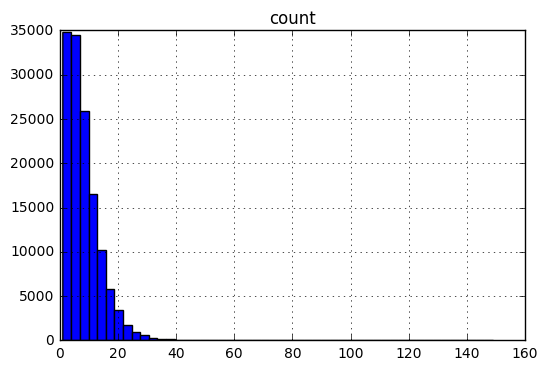

In [12]:
train.groupby('ID')['DEF'].agg(['count']).hist(bins=50)

In [13]:
def clean_trash(df):
    import re
    #несколько случаев когда берет подряд 2 кредита и статус не успел проставится - ставлю Х
    df['TEXT_PAYMENT_DISCIPLINE'] = df['TEXT_PAYMENT_DISCIPLINE'].fillna('X')
    #какой-то трешак в данных
    df['TEXT_PAYMENT_DISCIPLINE'] = df['TEXT_PAYMENT_DISCIPLINE'].map(lambda x: re.sub('\..+', '', x))
    return df

train = clean_trash(train)
test = clean_trash(test)

In [14]:
#считаю количество платежей
def count_payments(df):
    df['zeros']=df['TEXT_PAYMENT_DISCIPLINE'].str.replace('C','q').str.replace('X','q').str.replace('1','q').str.replace('2','q').str.replace('3','q').str.replace('4','q').str.replace('5','q')
    df['ones']=df['TEXT_PAYMENT_DISCIPLINE'].str.replace('C','q').str.replace('X','q').str.replace('0','q').str.replace('2','q').str.replace('3','q').str.replace('4','q').str.replace('5','q')
    df['twos']=df['TEXT_PAYMENT_DISCIPLINE'].str.replace('C','q').str.replace('X','q').str.replace('1','q').str.replace('0','q').str.replace('3','q').str.replace('4','q').str.replace('5','q')
    df['threes']=df['TEXT_PAYMENT_DISCIPLINE'].str.replace('C','q').str.replace('X','q').str.replace('1','q').str.replace('2','q').str.replace('0','q').str.replace('4','q').str.replace('5','q')
    df['fours']=df['TEXT_PAYMENT_DISCIPLINE'].str.replace('C','q').str.replace('X','q').str.replace('1','q').str.replace('2','q').str.replace('3','q').str.replace('0','q').str.replace('5','q')
    df['fives']=df['TEXT_PAYMENT_DISCIPLINE'].str.replace('C','q').str.replace('X','q').str.replace('1','q').str.replace('2','q').str.replace('3','q').str.replace('4','q').str.replace('0','q')
    df['bads']=df['TEXT_PAYMENT_DISCIPLINE'].str.replace('C','q').str.replace('X','q').str.replace('0','q')
    df['base']=df['TEXT_PAYMENT_DISCIPLINE'].str.replace('C','q').str.replace('X','q')
    return df

train = count_payments(train)
test = count_payments(test)

In [15]:
#худший статус за периоды
train['worst_status_3m']=train['TEXT_PAYMENT_DISCIPLINE'].str[:3].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
train['worst_status_6m']=train['TEXT_PAYMENT_DISCIPLINE'].str[:6].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
train['worst_status_12m']=train['TEXT_PAYMENT_DISCIPLINE'].str[:12].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
train['worst_status_24m']=train['TEXT_PAYMENT_DISCIPLINE'].str[:24].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
train['worst_status_36m']=train['TEXT_PAYMENT_DISCIPLINE'].str[:36].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
train['worst_status_48m']=train['TEXT_PAYMENT_DISCIPLINE'].str[:48].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
train['worst_status_60m']=train['TEXT_PAYMENT_DISCIPLINE'].str[:60].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))

In [16]:
#худший статус за периоды
test['worst_status_3m']=test['TEXT_PAYMENT_DISCIPLINE'].str[:3].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
test['worst_status_6m']=test['TEXT_PAYMENT_DISCIPLINE'].str[:6].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
test['worst_status_12m']=test['TEXT_PAYMENT_DISCIPLINE'].str[:12].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
test['worst_status_24m']=test['TEXT_PAYMENT_DISCIPLINE'].str[:24].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
test['worst_status_36m']=test['TEXT_PAYMENT_DISCIPLINE'].str[:36].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
test['worst_status_48m']=test['TEXT_PAYMENT_DISCIPLINE'].str[:48].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))
test['worst_status_60m']=test['TEXT_PAYMENT_DISCIPLINE'].str[:60].str.replace('C','0').str.replace('X','0').map(lambda x:int(max(str(x))))

In [17]:
#веду колонки которые просуммирую при группировке кредитов
sum_cols = []

#считаю количество разных платежей за периоды
def features_1(df):
    cols = []
    from itertools import product
    from tqdm import tqdm
    periods = [0,0,0,0,0,0,0]#[0,3,6,12,24,36,48]
    periods2 = [3,6,12,24,36,48,60]
    columns = ['zeros','ones','twos','threes','fours','fives','bads','base']
    for col,(per,per2) in tqdm(product(columns, zip(periods,periods2))):
        df[col+'_'+str(per)+':'+str(per2)]=df[col].str[per:per2].str.replace('q','').map(lambda x: len(x))
        cols.append(col+'_'+str(per)+':'+str(per2))
    for col in tqdm(columns):
        df[col]=df[col].str.replace('q','').map(lambda x: len(x))
    return df,cols

train,sum_cols = features_1(train)
test,_ = features_1(test)

56it [00:49,  1.01it/s]
100%|██████████| 8/8 [00:07<00:00,  1.01it/s]
56it [00:46,  1.08it/s]
100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


In [18]:
train['plan_lifetime'] = (train['DTIME_CREDIT_ENDDATE']-train['DTIME_CREDIT']).map(lambda x: x.days if x==x else np.nan )/365
train['fact_lifetime'] = (train['DTIME_CREDIT_ENDDATE_FACT']-train['DTIME_CREDIT']).map(lambda x: x.days if x==x else np.nan )/365
train['preschedule_time'] = (train['DTIME_CREDIT_ENDDATE']-train['DTIME_CREDIT_ENDDATE_FACT']).map(lambda x: x.days if x==x else np.nan )/365
train['lastupdate_time'] = (train['SK_DATE_DECISION']-train['DTIME_CREDIT_UPDATE']).map(lambda x: x.days if x==x else np.nan )/365
train['lastcredit_time'] = (train['SK_DATE_DECISION']-train['DTIME_CREDIT']).map(lambda x: x.days if x==x else np.nan )/365
train['lastclosed_time'] = (train['SK_DATE_DECISION']-train['DTIME_CREDIT_ENDDATE_FACT']).map(lambda x: x.days if x==x else np.nan )/365

In [19]:
test['plan_lifetime'] = (test['DTIME_CREDIT_ENDDATE']-test['DTIME_CREDIT']).map(lambda x: x.days if x==x else np.nan )/365
test['fact_lifetime'] = (test['DTIME_CREDIT_ENDDATE_FACT']-test['DTIME_CREDIT']).map(lambda x: x.days if x==x else np.nan )/365
test['preschedule_time'] = (test['DTIME_CREDIT_ENDDATE']-test['DTIME_CREDIT_ENDDATE_FACT']).map(lambda x: x.days if x==x else np.nan )/365
test['lastupdate_time'] = (test['SK_DATE_DECISION']-test['DTIME_CREDIT_UPDATE']).map(lambda x: x.days if x==x else np.nan )/365
test['lastcredit_time'] = (test['SK_DATE_DECISION']-test['DTIME_CREDIT']).map(lambda x: x.days if x==x else np.nan )/365
test['lastclosed_time'] = (test['SK_DATE_DECISION']-test['DTIME_CREDIT_ENDDATE_FACT']).map(lambda x: x.days if x==x else np.nan )/365

In [20]:
sum_cols2 =  ['CREDIT_COLLATERAL','CNT_CREDIT_PROLONG','AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT',\
              'AMT_CREDIT_SUM_OVERDUE','AMT_CREDIT_SUM_LIMIT','CREDIT_DELAY30','CREDIT_DELAY5',\
             'CREDIT_DELAY60','CREDIT_DELAY90','CREDIT_DELAY_MORE','AMT_REQ_SOURCE_YEAR','AMT_ANNUITY']

max_cols = ['CREDIT_DAY_OVERDUE','AMT_CREDIT_MAX_OVERDUE','AMT_REQ_SOURCE_HOUR','AMT_REQ_SOURCE_DAY',\
             'AMT_REQ_SOURCE_WEEK','AMT_REQ_SOURCE_MON','AMT_REQ_SOURCE_QRT']

max_cols.extend(['worst_status_3m','worst_status_6m','worst_status_12m','worst_status_24m','worst_status_36m',\
           'worst_status_48m','worst_status_60m','lastcredit_time'])

mean_cols = ['preschedule_time','plan_lifetime','fact_lifetime']
min_cols = ['plan_lifetime','fact_lifetime','lastcredit_time','lastclosed_time']
agg_col = []

In [182]:
X = train.groupby(['ID'])[sum_cols].sum().reset_index(drop = True)
X.columns = X.columns.map(lambda x: 'sum' + '_' + str(x))
X2 = train.groupby(['ID'])[sum_cols2].sum().reset_index(drop = True)
X2.columns = X2.columns.map(lambda x: 'sum' + '_' + str(x))
X3 = train.groupby(['ID'])[max_cols].max().reset_index(drop = True)
X3.columns = X3.columns.map(lambda x: 'max' + '_' + str(x))
X4 = train.groupby(['ID'])[mean_cols].mean().reset_index(drop = True)
X4.columns = X4.columns.map(lambda x: 'mean' + '_' + str(x))
X5 = train.groupby(['ID'])[min_cols].min().reset_index(drop = True)
X5.columns = X5.columns.map(lambda x: 'min' + '_' + str(x))

X6 = train.groupby(['ID'])['SK_DATE_DECISION'].count().reset_index(drop = True)
X6.name = 'count'

df = pd.concat([X,X2,X3,X4,X5,X6],axis=1)
ids = train.groupby(['ID'])['SK_DATE_DECISION'].max().index

target = train.groupby(['ID'])['DEF'].max().reset_index(drop = True)

In [183]:
temp = train[['ID','CREDIT_ACTIVE','CREDIT_TYPE','AMT_CREDIT_SUM']].groupby(['ID','CREDIT_ACTIVE','CREDIT_TYPE']).sum()\
.reset_index()

temp['cols'] = temp['CREDIT_ACTIVE'].astype(str)+'_'+temp['CREDIT_TYPE'].astype(str)

temp = temp.pivot(index='ID',columns='cols',values='AMT_CREDIT_SUM')
temp.columns = temp.columns.map(lambda x: 'mean_'+'CREDIT_ACTIVE'+'_'+'CREDIT_TYPE'+'_'+'AMT_CREDIT_SUM' + '_' + str(x))


df = pd.concat([df,temp.reset_index()],axis=1)

In [216]:
!conda update -all

usage: conda [-h] [-V] command ...
conda: error: unrecognized arguments: -all


In [184]:
def groupby_col_min(df,col_groupby,col_value):
    temp = df[['ID',col_groupby,col_value]].groupby(['ID',col_groupby]).min()\
    .reset_index().pivot(index='ID',columns=col_groupby,values=col_value)
    temp.columns = temp.columns.map(lambda x: 'min_'+col_groupby+'_'+col_value + '_' + str(x))
    return temp.reset_index(drop=True)

def groupby_col_max(df,col_groupby,col_value):
    temp = df[['ID',col_groupby,col_value]].groupby(['ID',col_groupby]).max()\
    .reset_index().pivot(index='ID',columns=col_groupby,values=col_value)
    temp.columns = temp.columns.map(lambda x: 'max_'+col_groupby+'_'+col_value + '_' + str(x))
    return temp.reset_index(drop=True)

def groupby_col_count(df,col_groupby,col_value):
    temp = df[['ID',col_groupby,col_value]].groupby(['ID',col_groupby]).count()\
    .reset_index().pivot(index='ID',columns=col_groupby,values=col_value)
    temp.columns = temp.columns.map(lambda x: 'count_'+col_groupby+'_'+col_value + '_' + str(x))
    return temp.reset_index(drop=True)

def groupby_col_sum(df,col_groupby,col_value):
    temp = df[['ID',col_groupby,col_value]].groupby(['ID',col_groupby]).sum()\
    .reset_index().pivot(index='ID',columns=col_groupby,values=col_value)
    temp.columns = temp.columns.map(lambda x: 'sum_'+col_groupby+'_'+col_value + '_' + str(x))
    return temp.reset_index(drop=True)

def groupby_col_mean(df,col_groupby,col_value):
    temp = df[['ID',col_groupby,col_value]].groupby(['ID',col_groupby]).mean()\
    .reset_index().pivot(index='ID',columns=col_groupby,values=col_value)
    temp.columns = temp.columns.map(lambda x: 'mean_'+col_groupby+'_'+col_value + '_' + str(x))
    return temp.reset_index(drop=True)

df = pd.concat([df,groupby_col_min(train,'CREDIT_ACTIVE', 'lastupdate_time')],axis=1)
df = pd.concat([df,groupby_col_min(train,'CREDIT_ACTIVE', 'lastcredit_time')],axis=1)
df = pd.concat([df,groupby_col_min(train,'CREDIT_CURRENCY', 'lastupdate_time')],axis=1)
df = pd.concat([df,groupby_col_min(train,'CREDIT_CURRENCY', 'lastcredit_time')],axis=1)
df = pd.concat([df,groupby_col_min(train,'CREDIT_TYPE', 'lastupdate_time')],axis=1)
df = pd.concat([df,groupby_col_min(train,'CREDIT_TYPE', 'lastcredit_time')],axis=1)

df = pd.concat([df,groupby_col_max(train,'CREDIT_ACTIVE', 'AMT_CREDIT_MAX_OVERDUE')],axis=1)
df = pd.concat([df,groupby_col_max(train,'CREDIT_CURRENCY', 'AMT_CREDIT_MAX_OVERDUE')],axis=1)
df = pd.concat([df,groupby_col_max(train,'CREDIT_TYPE', 'AMT_CREDIT_MAX_OVERDUE')],axis=1)

df = pd.concat([df,groupby_col_count(train,'CREDIT_CURRENCY', 'SK_DATE_DECISION')],axis=1)
df = pd.concat([df,groupby_col_count(train,'CREDIT_ACTIVE', 'SK_DATE_DECISION')],axis=1)

df = pd.concat([df,groupby_col_sum(train,'CREDIT_ACTIVE', 'AMT_CREDIT_SUM')],axis=1)
df = pd.concat([df,groupby_col_sum(train,'CREDIT_ACTIVE', 'AMT_ANNUITY')],axis=1)
df = pd.concat([df,groupby_col_sum(train,'CREDIT_CURRENCY', 'AMT_CREDIT_SUM')],axis=1)
df = pd.concat([df,groupby_col_sum(train,'CREDIT_CURRENCY', 'AMT_CREDIT_SUM_DEBT')],axis=1)
df = pd.concat([df,groupby_col_sum(train,'CREDIT_TYPE', 'AMT_CREDIT_SUM')],axis=1)
df = pd.concat([df,groupby_col_sum(train,'CREDIT_TYPE', 'CREDIT_COLLATERAL')],axis=1)
df = pd.concat([df,groupby_col_sum(train,'CREDIT_TYPE', 'AMT_CREDIT_SUM_DEBT')],axis=1)

df = pd.concat([df,groupby_col_mean(train,'CREDIT_ACTIVE', 'preschedule_time')],axis=1)
df = pd.concat([df,groupby_col_mean(train,'CREDIT_CURRENCY', 'preschedule_time')],axis=1)
df = pd.concat([df,groupby_col_mean(train,'CREDIT_TYPE', 'preschedule_time')],axis=1)
df = pd.concat([df,groupby_col_mean(train,'CREDIT_ACTIVE', 'plan_lifetime')],axis=1)
df = pd.concat([df,groupby_col_mean(train,'CREDIT_CURRENCY', 'plan_lifetime')],axis=1)
df = pd.concat([df,groupby_col_mean(train,'CREDIT_TYPE', 'plan_lifetime')],axis=1)
df = pd.concat([df,groupby_col_mean(train,'CREDIT_ACTIVE', 'fact_lifetime')],axis=1)
df = pd.concat([df,groupby_col_mean(train,'CREDIT_CURRENCY', 'fact_lifetime')],axis=1)
df = pd.concat([df,groupby_col_mean(train,'CREDIT_TYPE', 'fact_lifetime')],axis=1)

In [44]:
fi

,feature,importance
83,sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_5,1110
18,min_lastcredit_time,1088
84,sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_4,1056
65,sum_CREDIT_ACTIVE_AMT_CREDIT_SUM_0,831
169,min_CREDIT_ACTIVE_lastcredit_time_1,781
150,mean_CREDIT_ACTIVE_plan_lifetime_1,767
161,min_CREDIT_TYPE_lastcredit_time_4,738
31,min_CREDIT_ACTIVE_lastcredit_time_0,722
146,sum_CREDIT_TYPE_AMT_CREDIT_SUM_5,670
160,min_CREDIT_TYPE_lastcredit_time_5,664


In [185]:
col_nuls = {'count_CREDIT_ACTIVE_SK_DATE_DECISION_3',
 'count_CREDIT_CURRENCY_SK_DATE_DECISION_chf',
 'count_CREDIT_CURRENCY_SK_DATE_DECISION_eur',
 'count_CREDIT_CURRENCY_SK_DATE_DECISION_usd',
 'max_AMT_REQ_SOURCE_DAY',
 'max_AMT_REQ_SOURCE_WEEK',
 'max_CREDIT_ACTIVE_AMT_CREDIT_MAX_OVERDUE_3',
 'max_CREDIT_CURRENCY_AMT_CREDIT_MAX_OVERDUE_chf',
 'max_CREDIT_CURRENCY_AMT_CREDIT_MAX_OVERDUE_eur',
 'max_CREDIT_CURRENCY_AMT_CREDIT_MAX_OVERDUE_usd',
 'max_CREDIT_TYPE_AMT_CREDIT_MAX_OVERDUE_0',
 'max_CREDIT_TYPE_AMT_CREDIT_MAX_OVERDUE_10',
 'max_CREDIT_TYPE_AMT_CREDIT_MAX_OVERDUE_7',
 'max_CREDIT_TYPE_AMT_CREDIT_MAX_OVERDUE_8',
 'max_CREDIT_TYPE_AMT_CREDIT_MAX_OVERDUE_9',
 'max_CREDIT_TYPE_AMT_CREDIT_MAX_OVERDUE_99',
 'mean_CREDIT_ACTIVE_fact_lifetime_3',
 'mean_CREDIT_ACTIVE_plan_lifetime_3',
 'mean_CREDIT_ACTIVE_preschedule_time_3',
 'mean_CREDIT_CURRENCY_fact_lifetime_chf',
 'mean_CREDIT_CURRENCY_fact_lifetime_eur',
 'mean_CREDIT_CURRENCY_fact_lifetime_usd',
 'mean_CREDIT_CURRENCY_plan_lifetime_chf',
 'mean_CREDIT_CURRENCY_plan_lifetime_eur',
 'mean_CREDIT_CURRENCY_plan_lifetime_usd',
 'mean_CREDIT_CURRENCY_preschedule_time_chf',
 'mean_CREDIT_CURRENCY_preschedule_time_eur',
 'mean_CREDIT_TYPE_fact_lifetime_0',
 'mean_CREDIT_TYPE_fact_lifetime_10',
 'mean_CREDIT_TYPE_fact_lifetime_18',
 'mean_CREDIT_TYPE_fact_lifetime_7',
 'mean_CREDIT_TYPE_fact_lifetime_8',
 'mean_CREDIT_TYPE_fact_lifetime_9',
 'mean_CREDIT_TYPE_plan_lifetime_0',
 'mean_CREDIT_TYPE_plan_lifetime_10',
 'mean_CREDIT_TYPE_plan_lifetime_7',
 'mean_CREDIT_TYPE_plan_lifetime_8',
 'mean_CREDIT_TYPE_plan_lifetime_9',
 'mean_CREDIT_TYPE_preschedule_time_0',
 'mean_CREDIT_TYPE_preschedule_time_10',
 'mean_CREDIT_TYPE_preschedule_time_18',
 'mean_CREDIT_TYPE_preschedule_time_6',
 'mean_CREDIT_TYPE_preschedule_time_7',
 'mean_CREDIT_TYPE_preschedule_time_8',
 'mean_CREDIT_TYPE_preschedule_time_9',
 'mean_CREDIT_TYPE_preschedule_time_99',
 'min_CREDIT_ACTIVE_lastcredit_time_3',
 'min_CREDIT_ACTIVE_lastupdate_time_3',
 'min_CREDIT_CURRENCY_lastcredit_time_chf',
 'min_CREDIT_CURRENCY_lastcredit_time_eur',
 'min_CREDIT_CURRENCY_lastcredit_time_usd',
 'min_CREDIT_CURRENCY_lastupdate_time_chf',
 'min_CREDIT_CURRENCY_lastupdate_time_eur',
 'min_CREDIT_CURRENCY_lastupdate_time_usd',
 'min_CREDIT_TYPE_lastcredit_time_0',
 'min_CREDIT_TYPE_lastcredit_time_10',
 'min_CREDIT_TYPE_lastcredit_time_7',
 'min_CREDIT_TYPE_lastcredit_time_8',
 'min_CREDIT_TYPE_lastcredit_time_9',
 'min_CREDIT_TYPE_lastupdate_time_0',
 'min_CREDIT_TYPE_lastupdate_time_10',
 'min_CREDIT_TYPE_lastupdate_time_7',
 'min_CREDIT_TYPE_lastupdate_time_8',
 'min_CREDIT_TYPE_lastupdate_time_9',
 'sum_CREDIT_ACTIVE_AMT_ANNUITY_3',
 'sum_CREDIT_ACTIVE_AMT_CREDIT_SUM_3',
 'sum_CREDIT_COLLATERAL',
 'sum_CREDIT_CURRENCY_AMT_CREDIT_SUM_DEBT_chf',
 'sum_CREDIT_CURRENCY_AMT_CREDIT_SUM_DEBT_eur',
 'sum_CREDIT_CURRENCY_AMT_CREDIT_SUM_DEBT_usd',
 'sum_CREDIT_CURRENCY_AMT_CREDIT_SUM_chf',
 'sum_CREDIT_CURRENCY_AMT_CREDIT_SUM_eur',
 'sum_CREDIT_CURRENCY_AMT_CREDIT_SUM_usd',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_0',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_10',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_7',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_8',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_9',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_0',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_10',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_7',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_8',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_9',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_99',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_0',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_1',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_10',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_18',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_19',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_3',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_4',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_5',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_6',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_7',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_8',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_9',
 'sum_CREDIT_TYPE_CREDIT_COLLATERAL_99',
 'sum_fours_0:12',
 'sum_fours_0:24',
 'sum_fours_0:3',
 'sum_fours_0:36',
 'sum_fours_0:6',
 'sum_threes_0:12',
 'sum_threes_0:24',
 'sum_threes_0:3',
 'sum_threes_0:36',
 'sum_threes_0:6',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_0',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_10',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_18',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_7',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_8',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_9',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_0',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_10',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_7',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_8',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_9',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_18',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_19',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_6',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_7',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_9',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_99',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_3_1',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_3_18',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_3_4',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_3_5'}

In [186]:
col_less_10 = {'count_CREDIT_ACTIVE_SK_DATE_DECISION_2',
 'max_AMT_REQ_SOURCE_HOUR',
 'max_CREDIT_ACTIVE_AMT_CREDIT_MAX_OVERDUE_2',
 'max_CREDIT_TYPE_AMT_CREDIT_MAX_OVERDUE_18',
 'max_CREDIT_TYPE_AMT_CREDIT_MAX_OVERDUE_19',
 'max_CREDIT_TYPE_AMT_CREDIT_MAX_OVERDUE_3',
 'max_worst_status_12m',
 'max_worst_status_24m',
 'max_worst_status_36m',
 'max_worst_status_6m',
 'mean_CREDIT_ACTIVE_fact_lifetime_1',
 'mean_CREDIT_ACTIVE_preschedule_time_2',
 'mean_CREDIT_CURRENCY_preschedule_time_usd',
 'mean_CREDIT_TYPE_fact_lifetime_6',
 'mean_CREDIT_TYPE_fact_lifetime_99',
 'mean_CREDIT_TYPE_plan_lifetime_99',
 'sum_CREDIT_DELAY90',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_6',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_99',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_DEBT_6',
 'sum_fives_0:12',
 'sum_fives_0:24',
 'sum_fives_0:3',
 'sum_fives_0:36',
 'sum_fives_0:48',
 'sum_fives_0:6',
 'sum_fives_0:60',
 'sum_fours_0:48',
 'sum_twos_0:12',
 'sum_twos_0:24',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_6',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_99',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_6',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_99',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_1',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_3',
 'min_CREDIT_TYPE_lastcredit_time_6',
 'min_CREDIT_TYPE_lastupdate_time_99',
 'sum_CREDIT_ACTIVE_AMT_ANNUITY_2',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_18',
 'sum_fours_0:60'}

In [187]:
df = df[list(set(df.columns.values)-set(col_nuls)-set(col_less_10))]

In [160]:
X.shape,X2.shape,X3.shape,df.shape

((135155, 56), (135155, 13), (135155, 15), (135155, 185))

# hyperopt

In [51]:
import logging
logger = logging.getLogger('server_logger')
logger.setLevel(logging.INFO)

# create file handler which logs even debug messages
fh = logging.FileHandler('server_xgb.log')
fh.setLevel(logging.INFO)

# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
ch.setFormatter(formatter)
fh.setFormatter(formatter)
# add the handlers to logger
logger.addHandler(ch)
logger.addHandler(fh)
#logger.info('This should go to both console and file')

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [54]:
def score(params):
    #seed = int(np.random.rand()*100000)
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
         
    logger.info('Training with params:')
    logger.info(params)
        
    cv_res = xgb.cv(params,xgb_train,num_boost_round=1000,nfold=5,stratified=True,)
       
    score = np.max(cv_res['test-auc-mean'])
    logger.info('score = %f' % score)
    logger.info('best_rounds = %f' % np.argmax(cv_res['test-auc-mean']))
    
    return {'loss': -score , 'status': STATUS_OK}

In [56]:
space = {
    'eta' : 0.01,
    'max_depth' : hp.quniform('max_depth',3,20,1),
    'min_child_weight' : hp.quniform('min_child_weight',1,7,1),
    'subsample' : hp.quniform('subsample',0.6,1,0.1),
    'gamma' : hp.quniform('gamma',0,0.1,0.01),
    'alpha' : hp.quniform('alpha',0,1,0.1),
    'lambda' : hp.quniform('lambda',0,1,0.1),
    'colsample_bytree' : hp.quniform('colsample_bytree',0.6,1,0.1),
    'objective' : 'binary:logistic' ,
    'eval_metric':'auc',
    'booster' : 'gbtree',
    'seed': RANDOM_STATE
}

In [57]:
trials = Trials()
best = fmin(fn = score,
            space=space,
            algo = tpe.suggest, 
            trials=trials,
            max_evals=150
        )

2017-08-26 21:38:44 - INFO - Training with params:
2017-08-26 21:38:44 - INFO - {'colsample_bytree': 1.0, 'eval_metric': 'auc', 'min_child_weight': 5, 'subsample': 1.0, 'eta': 0.01, 'objective': 'binary:logistic', 'alpha': 0.4, 'booster': 'gbtree', 'seed': 2017, 'max_depth': 15, 'gamma': 0.05, 'lambda': 0.4}
2017-08-26 21:55:04 - INFO - score = 0.656053
2017-08-26 21:55:04 - INFO - best_rounds = 133.000000
2017-08-26 21:55:04 - INFO - Training with params:
2017-08-26 21:55:04 - INFO - {'colsample_bytree': 0.9, 'eval_metric': 'auc', 'min_child_weight': 2, 'subsample': 0.8, 'eta': 0.01, 'objective': 'binary:logistic', 'alpha': 0.9, 'booster': 'gbtree', 'seed': 2017, 'max_depth': 13, 'gamma': 0.0, 'lambda': 1.0}
2017-08-26 22:10:34 - INFO - score = 0.666572
2017-08-26 22:10:34 - INFO - best_rounds = 297.000000
2017-08-26 22:10:34 - INFO - Training with params:
2017-08-26 22:10:34 - INFO - {'colsample_bytree': 0.9, 'eval_metric': 'auc', 'min_child_weight': 3, 'subsample': 0.700000000000000

KeyboardInterrupt: 

In [ ]:
2017-08-27 06:15:06 - INFO - {'colsample_bytree': 0.8, 'eval_metric': 'auc', 'min_child_weight': 5, 'subsample': 0.6000000000000001, 'eta': 0.01, 'objective': 'binary:logistic', 'alpha': 0.5, 'booster': 'gbtree', 'seed': 2017, 'max_depth': 5, 'gamma': 0.01, 'lambda': 1.0}
2017-08-27 06:21:07 - INFO - score = 0.675114
2017-08-27 06:21:07 - INFO - best_rounds = 732.000000
        
2017-08-27 05:46:46 - INFO - {'colsample_bytree': 1.0, 'eval_metric': 'auc', 'min_child_weight': 5, 'subsample': 0.8, 'eta': 0.01, 'objective': 'binary:logistic', 'alpha': 0.4, 'booster': 'gbtree', 'seed': 2017, 'max_depth': 4, 'gamma': 0.01, 'lambda': 0.8}
2017-08-27 05:52:04 - INFO - score = 0.674951
2017-08-27 05:52:04 - INFO - best_rounds = 968.000000
        
2017-08-27 04:36:24 - INFO - {'colsample_bytree': 0.8, 'eval_metric': 'auc', 'min_child_weight': 6, 'subsample': 0.6000000000000001, 'eta': 0.01, 'objective': 'binary:logistic', 'alpha': 0.4, 'booster': 'gbtree', 'seed': 2017, 'max_depth': 6, 'gamma': 0.01, 'lambda': 1.0}
2017-08-27 04:43:20 - INFO - score = 0.675366
2017-08-27 04:43:20 - INFO - best_rounds = 608.000000
        
2017-08-27 03:23:15 - INFO - {'colsample_bytree': 0.7000000000000001, 'eval_metric': 'auc', 'min_child_weight': 6, 'subsample': 0.7000000000000001, 'eta': 0.01, 'objective': 'binary:logistic', 'alpha': 0.5, 'booster': 'gbtree', 'seed': 2017, 'max_depth': 4, 'gamma': 0.0, 'lambda': 0.6000000000000001}
2017-08-27 03:27:44 - INFO - score = 0.675089
2017-08-27 03:27:44 - INFO - best_rounds = 987.000000

# hyperopt end

In [143]:
#df = df.fillna(0)

In [100]:
j=0
for i in df.columns.sort_values():
    if i==j:
        print(i)
    else:
        j=i[:]

In [188]:
params = {
    'max_depth': 6,
    'min_child_weight': 6,
    'gamma': 0.0,
    'colsample_bytree': 0.8,
    'subsample': 0.6,
    'scale_pos_weight':1,
    'objective':'binary:logistic' ,
    'eta': 0.01,
    'alpha': 0.4,
    'lambda': 1,
    'eval_metric':'auc',
    #'silent': 1,
    'verbose_eval': True,
    'seed': RANDOM_STATE
}

In [107]:
target.shape

(135155,)

In [108]:
df.shape

(170005, 184)

In [189]:
xgb_train = xgb.DMatrix(df, label=target)

In [190]:
cv_res = xgb.cv(params,xgb_train,num_boost_round=1200,nfold=5,stratified=True,)

In [191]:
num_boost_best = np.argmax(cv_res['test-auc-mean'])

In [192]:
print np.argmax(cv_res['test-auc-mean']),np.max(cv_res['test-auc-mean'])

1079 0.6986206


In [166]:
print np.argmax(cv_res['test-auc-mean']),np.max(cv_res['test-auc-mean'])

1018 0.6973324


In [163]:
model_fit = xgb.train(params, xgb_train, num_boost_round=num_boost_best, 
            #evals = watchlist, 
            maximize=True,
            verbose_eval=False
        )

In [164]:
fi = pd.DataFrame(model_fit.get_score(importance_type='weight').items(), columns=['feature','importance']).sort_values('importance', ascending=False)
set(fi[fi['importance']<10]['feature'])

{'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_6',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_99',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_6',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_99',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_1',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_3',
 'min_CREDIT_TYPE_lastcredit_time_6',
 'min_CREDIT_TYPE_lastupdate_time_99',
 'sum_CREDIT_ACTIVE_AMT_ANNUITY_2',
 'sum_CREDIT_TYPE_AMT_CREDIT_SUM_18',
 'sum_fours_0:60'}

In [165]:
set(df.columns.values)-set(fi['feature'])

{'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_0',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_10',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_18',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_7',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_8',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_0_9',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_0',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_10',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_7',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_8',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_1_9',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_18',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_19',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_6',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_7',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_9',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_2_99',
 'mean_CREDIT_ACTIVE_CREDIT_TYPE_AMT_CREDIT_SUM_3_1',
 'mean_CREDIT_ACTIVE_C

# predict

In [167]:
X = test.groupby(['ID'])[sum_cols].sum().reset_index(drop = True)
X.columns = X.columns.map(lambda x: 'sum' + '_' + str(x))
X2 = test.groupby(['ID'])[sum_cols2].sum().reset_index(drop = True)
X2.columns = X2.columns.map(lambda x: 'sum' + '_' + str(x))
X3 = test.groupby(['ID'])[max_cols].max().reset_index(drop = True)
X3.columns = X3.columns.map(lambda x: 'max' + '_' + str(x))
X4 = test.groupby(['ID'])[mean_cols].mean().reset_index(drop = True)
X4.columns = X4.columns.map(lambda x: 'mean' + '_' + str(x))
X5 = test.groupby(['ID'])[min_cols].mean().reset_index(drop = True)
X5.columns = X5.columns.map(lambda x: 'min' + '_' + str(x))
X6 = test.groupby(['ID'])['SK_DATE_DECISION'].count().reset_index(drop = True)
X6.name = 'count'

df_test = pd.concat([X,X2,X3,X4,X5,X6],axis=1)
ids_test = test.groupby(['ID'])['NUM_SOURCE'].max().reset_index()

In [168]:
temp = test[['ID','CREDIT_ACTIVE','CREDIT_TYPE','AMT_CREDIT_SUM']].groupby(['ID','CREDIT_ACTIVE','CREDIT_TYPE']).sum()\
.reset_index()

temp['cols'] = temp['CREDIT_ACTIVE'].astype(str)+'_'+temp['CREDIT_TYPE'].astype(str)

temp = temp.pivot(index='ID',columns='cols',values='AMT_CREDIT_SUM')
temp.columns = temp.columns.map(lambda x: 'mean_'+'CREDIT_ACTIVE'+'_'+'CREDIT_TYPE'+'_'+'AMT_CREDIT_SUM' + '_' + str(x))


df_test = pd.concat([df_test,temp.reset_index()],axis=1)

In [169]:
df_test = pd.concat([df_test,groupby_col_min(test,'CREDIT_ACTIVE', 'lastupdate_time')],axis=1)
df_test = pd.concat([df_test,groupby_col_min(test,'CREDIT_ACTIVE', 'lastcredit_time')],axis=1)
df_test = pd.concat([df_test,groupby_col_min(test,'CREDIT_CURRENCY', 'lastupdate_time')],axis=1)
df_test = pd.concat([df_test,groupby_col_min(test,'CREDIT_CURRENCY', 'lastcredit_time')],axis=1)
df_test = pd.concat([df_test,groupby_col_min(test,'CREDIT_TYPE', 'lastupdate_time')],axis=1)
df_test = pd.concat([df_test,groupby_col_min(test,'CREDIT_TYPE', 'lastcredit_time')],axis=1)

df_test = pd.concat([df_test,groupby_col_max(test,'CREDIT_ACTIVE', 'AMT_CREDIT_MAX_OVERDUE')],axis=1)
df_test = pd.concat([df_test,groupby_col_max(test,'CREDIT_CURRENCY', 'AMT_CREDIT_MAX_OVERDUE')],axis=1)
df_test = pd.concat([df_test,groupby_col_max(test,'CREDIT_TYPE', 'AMT_CREDIT_MAX_OVERDUE')],axis=1)

df_test = pd.concat([df_test,groupby_col_count(test,'CREDIT_CURRENCY', 'SK_DATE_DECISION')],axis=1)
df_test = pd.concat([df_test,groupby_col_count(test,'CREDIT_ACTIVE', 'SK_DATE_DECISION')],axis=1)

df_test = pd.concat([df_test,groupby_col_sum(test,'CREDIT_ACTIVE', 'AMT_CREDIT_SUM')],axis=1)
df_test = pd.concat([df_test,groupby_col_sum(test,'CREDIT_ACTIVE', 'AMT_ANNUITY')],axis=1)
df_test = pd.concat([df_test,groupby_col_sum(test,'CREDIT_CURRENCY', 'AMT_CREDIT_SUM')],axis=1)
df_test = pd.concat([df_test,groupby_col_sum(test,'CREDIT_CURRENCY', 'AMT_CREDIT_SUM_DEBT')],axis=1)
df_test = pd.concat([df_test,groupby_col_sum(test,'CREDIT_TYPE', 'AMT_CREDIT_SUM')],axis=1)
df_test = pd.concat([df_test,groupby_col_sum(test,'CREDIT_TYPE', 'CREDIT_COLLATERAL')],axis=1)
df_test = pd.concat([df_test,groupby_col_sum(test,'CREDIT_TYPE', 'AMT_CREDIT_SUM_DEBT')],axis=1)

df_test = pd.concat([df_test,groupby_col_mean(test,'CREDIT_ACTIVE', 'preschedule_time')],axis=1)
df_test = pd.concat([df_test,groupby_col_mean(test,'CREDIT_CURRENCY', 'preschedule_time')],axis=1)
df_test = pd.concat([df_test,groupby_col_mean(test,'CREDIT_TYPE', 'preschedule_time')],axis=1)
df_test = pd.concat([df_test,groupby_col_mean(test,'CREDIT_ACTIVE', 'plan_lifetime')],axis=1)
df_test = pd.concat([df_test,groupby_col_mean(test,'CREDIT_CURRENCY', 'plan_lifetime')],axis=1)
df_test = pd.concat([df_test,groupby_col_mean(test,'CREDIT_TYPE', 'plan_lifetime')],axis=1)
df_test = pd.concat([df_test,groupby_col_mean(test,'CREDIT_ACTIVE', 'fact_lifetime')],axis=1)
df_test = pd.concat([df_test,groupby_col_mean(test,'CREDIT_CURRENCY', 'fact_lifetime')],axis=1)
df_test = pd.concat([df_test,groupby_col_mean(test,'CREDIT_TYPE', 'fact_lifetime')],axis=1)

In [170]:
df_test = df_test[list(set(df_test.columns.values)-set(col_nuls)-set(col_less_10))]

In [171]:
for i in set(df.columns)-set(df_test.columns):
    df_test.loc[:,i] = np.nan

In [172]:
#df_test = df_test.fillna(0)

xgb_test = xgb.DMatrix(df_test[df.columns])

In [173]:
ids_test['Score'] = model_fit.predict(xgb_test)

In [174]:
ids_test[['ID','Score']].to_csv('submission/sub9.csv',index=False)

In [30]:
samplesubmission[:1]

,ID,Score
0,174640,0.5


# Submission

1. local: 0.6394443 - public: 0.642259 --только на статусах из pmstring
2. local: 0.669483  - public: 0.678312  добавил агрегаты по суммам
3. local: 0.6706974 - public: 0.682243 - изменил признаки из pmstring (суммирую с 0го периода, а не скользящими)
4. local: 0.6740674 - public: 0.682199 добавил признаки "количество запросов в бюро, количество просрочек
5. local: 0.6794322 - public: 0.684776 добавил признаки со временем
6. local: 0.6810232 - public: 0.690776 исправил баг
7. local: 0.6914358 - public: 0.704496 добавил кросс переменных
8. local: 0.6949604 - public: 0.708006 еще немного кросс переменных
9. local: 0.6973324 - public: добавил двойную кросс переменную

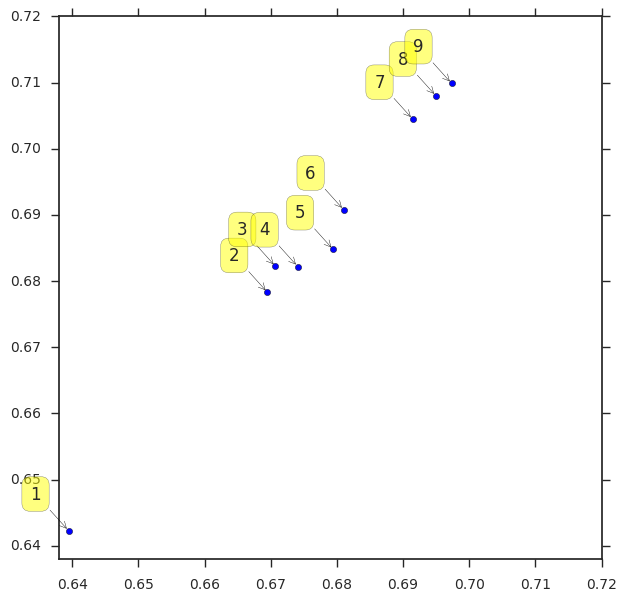

In [181]:
data = {1:[0.6394443,0.642259],
        2:[0.669483,0.6783128456394],
        3:[0.6706974,0.682243],
        4:[0.6740674,0.682199],
        5:[0.6794322,0.6847760771968],
        6:[0.6810232,0.69077653969932],
        7:[0.6914358, 0.704496],
        8:[0.6949604, 0.708006],
        9:[0.6973324, 0.709875]
       }
data = pd.DataFrame(data).T
#data.columns = ['local','public']

labels = data.index

plt.figure(figsize=(7, 7))
plt.scatter(data.loc[:, 0], data.loc[:, 1],
            cmap=plt.get_cmap('Spectral'))
plt.xlim(0.638,  0.72)
plt.ylim(0.638,  0.72)
    
for label, x, y in zip(labels, data.loc[:, 0], data.loc[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

In [176]:
data.columns = ['local','public']

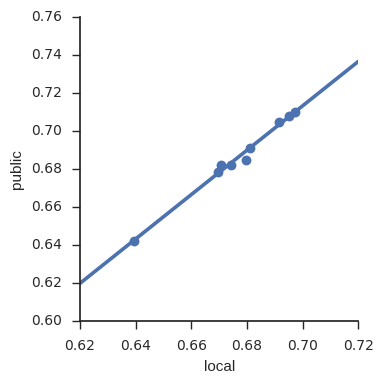

In [177]:
import seaborn as sns
sns.set(style="ticks")

# Plot tip as a function of toal bill across days
g = sns.lmplot(x="local", y="public", data=data,
                # truncate=True,
                # col_wrap=2, 
                ci=None, 
                palette="muted",
                scatter_kws={"s": 50, "alpha": 1},
                size=4)
# Use more informative axis labels than are provided by default
g.set_axis_labels("local", "public")

In [ ]:
# from sklearn.calibration import CalibratedClassifierCV, calibration_curve
# from sklearn.metrics import (brier_score_loss, precision_score, recall_score, f1_score)
# import matplotlib.pyplot as plt

# prob_pos = train['oof_predict']
# #prob_pos = model_fit.predict(xgb_test)
# y_test = train['cardio']

# clf_score = brier_score_loss(y_test, prob_pos, pos_label=y_test.max())

# fig = plt.figure(1, figsize=(10, 10))
# ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
# ax2 = plt.subplot2grid((3, 1), (2, 0))


# ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
# fraction_of_positives, mean_predicted_value = \
#             calibration_curve(y_test, prob_pos, n_bins=100)    
    
# ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % ('name', clf_score))

# ax2.hist(prob_pos, range=(0, 1), bins=100, label='name',
#                  histtype="step", lw=2)